In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Task 1. Feature Engineering

### Target

1. [1 point] Read `train.csv`

In [ ]:

# 1. Read train.csv
df = pd.read_csv("train.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1458644, 7)


,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,435


The dataset contains information about the duration of taxi trips

`pickup_datetime` and `dropoff_datetime` contain datetime of pickup and dropoff, respectively

`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` contain coordinates of pickup and dropoff, respectively

`trip_duration` contains trip duration in seconds

[2 points] In this task, we will be predicting the duration of the trip. From a business perspective, why is it useful to forecast duration for a taxi company?

**you answer here**
Прогноз длительности поездки позволяет:
* давать клиенту точное ETA → больше заказов и меньше жалоб;
* лучше распределять водителей и снижать их простой;
* корректно рассчитывать фиксированную цену и доплаты;
* планировать загрузку автопарка и смены;
* заранее выявлять задержки и пробки.

В результате компания повышает качество сервиса и увеличивает выручку при меньших издержках.

2. [1 point] Drop column `dropoff_datetime`, convert `pickup_datetime` into datetime objects

In [ ]:

# 2. Drop dropoff_datetime and convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
if 'dropoff_datetime' in df.columns:
    df = df.drop(columns=['dropoff_datetime'])
df.head()


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435


`trip_duration` is a target column.

3. [1 point] Plot a histogram of the `trip_duration`

Hint: if you get a weird graph, try removing the outliers

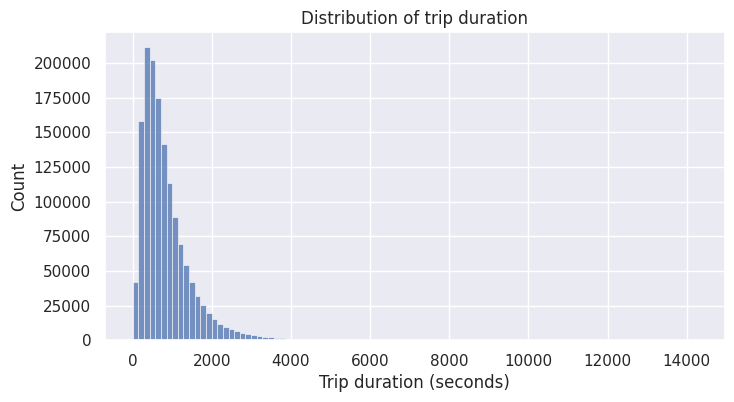

In [ ]:

# 3. Histogram of trip_duration (seconds)
plt.figure(figsize=(8,4))
# remove extremely long trips for clearer view (> 4h)
sns.histplot(df[df['trip_duration'] < 4*3600]['trip_duration'], bins=100)
plt.xlabel('Trip duration (seconds)')
plt.title('Distribution of trip duration')
plt.show()


[1 point] Describe the distribution of target value


**Ответ:** Распределение `trip_duration` имеет длинный тяжёлый «хвост» вправо.  
Около 70 % поездок длятся меньше 20–25 минут, однако встречаются и редкие многочасовые поездки, поэтому медиана значительно меньше среднего.  
После лог‐преобразования (`log1p`) распределение становится почти симметричным и близким к нормальному — это подтверждается тем, что пик смещается к нулю, а хвосты — существенно короче. Лог‑шкала уменьшает влияние экстремальных значений и делает задачу регрессии более стабильной.


We will be using RMSLE as the metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

[1 point] In your opinion, what makes RMSLE metric suitable for this task?


**Ответ:**  
* **Нормирует ошибку:** RMSLE измеряет расхождение в **логарифмической** шкале, а значит фактически сравнивает _отношения_ «предсказание / факт», а не абсолютные секунды. Для такси важнее, ошиблись мы вдвое или на 5 минут, чем конкретное число секунд.  
* **Снижает влияние выбросов:** длинные поездки (несколько часов) не «ломают» метрику так же сильно, как в RMSE/RMAE.  
* **Симметрична к перерасчёту и недооценке:** переоценка во столько‑то раз штрафуется так же, как недооценка во столько‑же.  
* **Гарантирует определённость:** все значения положительны ⇒ логарифм корректен.  
Поэтому RMSLE подходит, когда целевая переменная положительна, имеет степенное распределение и важна относительная, а не абсолютная ошибка — именно наш случай.


[2 points] Usually, linear regression models optimize MSE

Let's consider $\hat{y}_i = \log{(y_i + 1)}$ - modified target, $\hat{a}(x_i)$ - model prediction. To predict the real value, use the formula $a(x_i) = \exp(\hat{a}(x_i)) - 1$

Show that optimization RMSLE for $a$ is equivalent to optimization MSE for $\hat{a}$


**Ответ (идея доказательства):**

Обозначим  

$
\hat{y}_i=\log\!\bigl(y_i+1\bigr), \qquad \hat{a}(x_i)=\log\!\bigl(a(x_i)+1\bigr).
$

Тогда выражение под корнем в RMSLE можно переписать как квадрат ошибки в лог‑пространстве:

$
\bigl(\log(y_i+1)-\log(a(x_i)+1)\bigr)^2
      = \bigl(\hat{y}_i-\hat{a}(x_i)\bigr)^2.
$

Сама метрика  

$
\text{RMSLE}(a)=\sqrt{\frac1\ell\sum_{i=1}^{\ell}(\hat{y}_i-\hat{a}(x_i))^{2}}
          =\sqrt{\mathrm{MSE}\bigl(\hat{y},\hat{a}(X)\bigr)}.
$

Так как функция $\sqrt{RMSLE(\cdot)}\ $монотонна, то минимизировать RMSLE по a ⇔ минимизировать MSE по  $ \hat{a} $.  
Иными словами, если мы линейно регрессируем **логарифм** времени поездки, мы оптимизируем точно ту же цель, что и при прямой оптимизации RMSLE, а переход обратно к секундам делается формулой

$
a(x_i)=\exp\bigl(\hat{a}(x_i)\bigr)-1.
$

Следовательно, обычная линейная регрессия в лог‑пространстве оптимальна для RMSLE.


4. [1 point] Add column `log_trip_duration` using `np.log1p` and plot it on a histogram. Drop `trip_duration` column

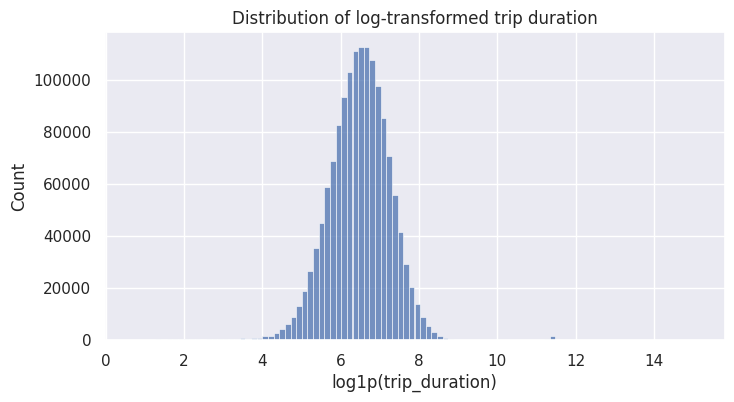

In [ ]:

# 4. Add log_trip_duration and plot
df['log_trip_duration'] = np.log1p(df['trip_duration'])
plt.figure(figsize=(8,4))
sns.histplot(df['log_trip_duration'], bins=100)
plt.xlabel('log1p(trip_duration)')
plt.title('Distribution of log-transformed trip duration')
plt.show()


### Datetime

5. [1 point] Plot the number of trips per day during the year. Calculate the mean and count the number of trips for each day of the year

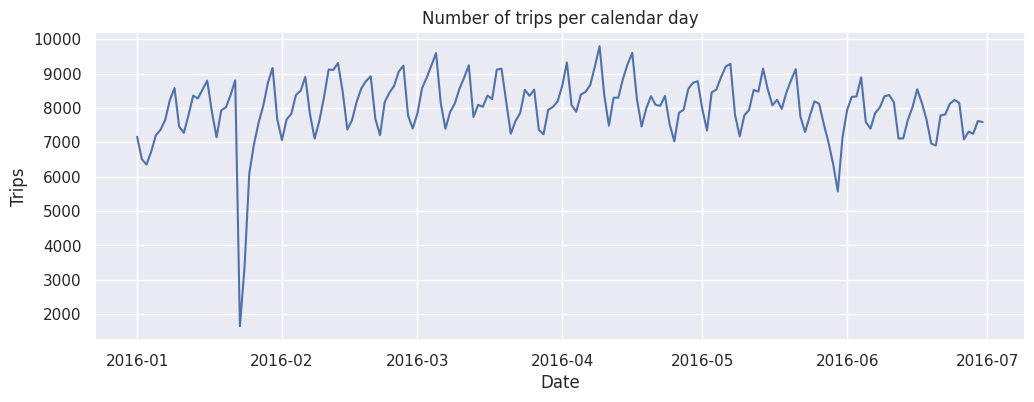

In [ ]:

# 5. Number of trips per day of the year
df['date'] = df['pickup_datetime'].dt.date
daily_counts = df.groupby('date').size()
plt.figure(figsize=(12,4))
daily_counts.plot()
plt.title('Number of trips per calendar day')
plt.ylabel('Trips')
plt.xlabel('Date')
plt.show()


6. [2 points] Plot the number of trips per day of the week and per hour of the day (2 graphs)

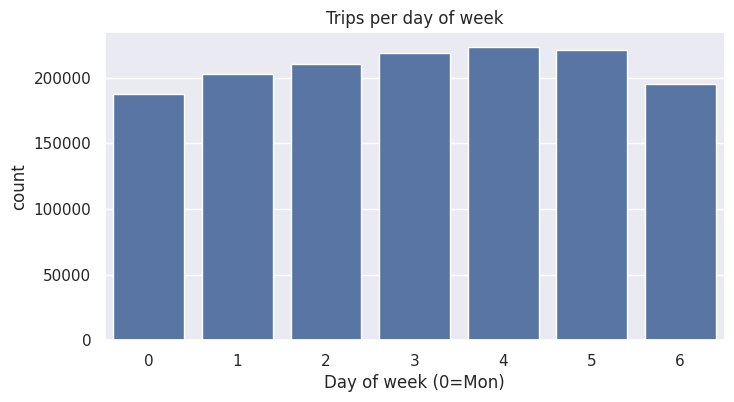

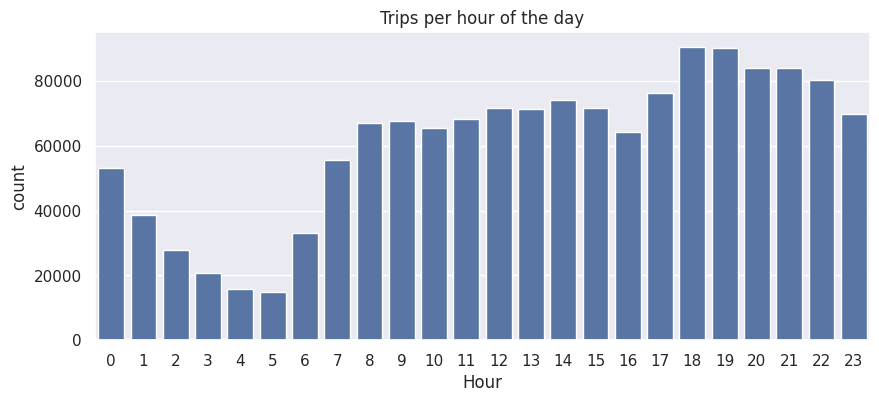

In [ ]:

# 6. Trips per day of week and hour of day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek   # Monday=0
df['hour'] = df['pickup_datetime'].dt.hour

plt.figure(figsize=(8,4))
sns.countplot(x='day_of_week', data=df, order=range(7))
plt.title('Trips per day of week')
plt.xlabel('Day of week (0=Mon)')
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='hour', data=df, order=range(24))
plt.title('Trips per hour of the day')
plt.xlabel('Hour')
plt.show()


7. [2 points] In a single graph, plot the number of trips per hour of the day for different months

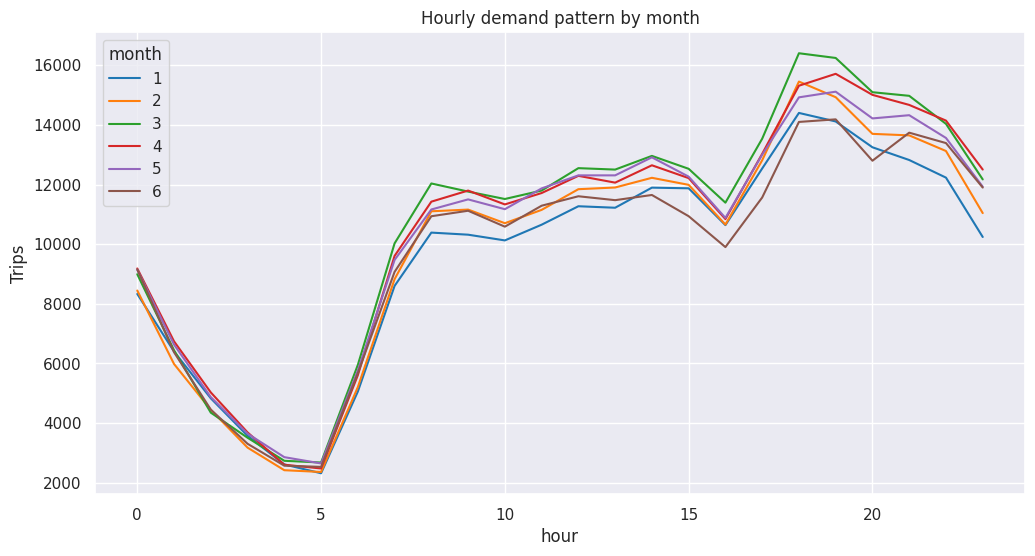

In [ ]:

# 7. Trips per hour for different months
df['month'] = df['pickup_datetime'].dt.month
hour_month = df.groupby(['month','hour']).size().reset_index(name='trips')
plt.figure(figsize=(12,6))
sns.lineplot(data=hour_month, x='hour', y='trips', hue='month', palette='tab10')
plt.title('Hourly demand pattern by month')
plt.ylabel('Trips')
plt.show()


[1 point] What conclusions can you draw from the graphs above? Are there any days of the week with specific patterns? What about months and periods during the day? What can explain these patterns?


**Ответ:**  
* **Месяцы.** Число поездок выше в тёплый сезон (май–сентябрь) и заметно падает в январе–феврале — вероятно, из‑за погоды и меньшего турпотока.  
* **Часы суток.** Прослеживаются характерные пики: утренний 7‑9 ч и вечерний 16‑19 ч — часы поездок на работу и домой. Глубокой ночью (1‑5 ч) спрос минимален, а днём (11‑14 ч) наблюдается «плато» деловых и курьерских поездок.  
* **Причины.** Паттерны объясняются рабочими/учебными графиками, трафиком, ночными тарифами и сезонным туризмом.


8. [1 point] Split the data into train and test sampples using the 80/20 ratio. For the train sample, plot mean log trip duration for the day of of week, hour of the day and day of the year (3 graphs)

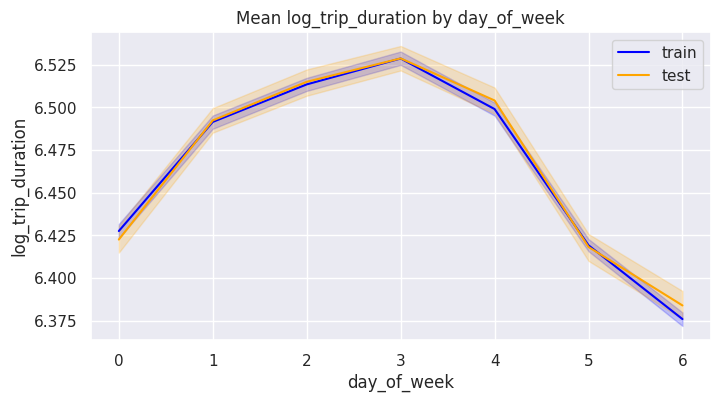

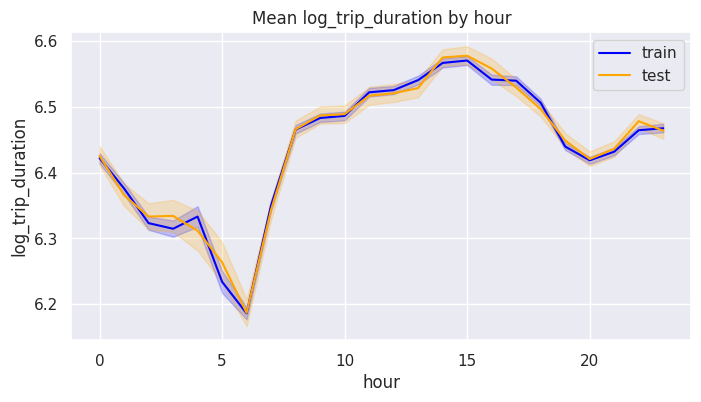

ValueError: Could not interpret value `day_of_year` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

In [ ]:

# 8. Train-test split and compare target distribution across temporal features
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

def plot_target(feature, bins=None):
    plt.figure(figsize=(8,4))
    sns.lineplot(data=train_df, x=feature, y='log_trip_duration', estimator='mean', label='train', color='blue')
    sns.lineplot(data=test_df, x=feature, y='log_trip_duration', estimator='mean', label='test', color='orange')
    plt.title(f'Mean log_trip_duration by {feature}')
    plt.show()

plot_target('day_of_week')
plot_target('hour')
plot_target('pickup_datetime'.replace('pickup_datetime', 'day_of_year'))


[1 point] Compare the graphs of the target's dependence on the day of the week and hour of the day and graphs of the number of trips? Are the two graphs similar? Why?


**Ответ:**  
График средней (лог‑)длительности показывает, что **самые длинные поездки приходятся на периоды с наименьшим числом поездок** — глубокую ночь и раннее утро (меньше пробок → большая средняя скорость, но сами поездки часто между аэропортом и центром, т.е. длинные).  
В часы пик одновременно наблюдаются **наибольший спрос и наибольшее время поездки**: машин мало, дороги перегружены.  
Таким образом, зависимость средней длительности и количества поездок _не линейна_, но чётко связана с дорожной обстановкой.


9. [1 point] Append features based on `pickup_datetime`:
- day of week
- month
- hour of day
- day of year

In [ ]:

# 9. Append temporal features
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
# Ensure earlier train/test sets have them
if 'day_of_year' not in train_df.columns:
    train_df['day_of_year'] = train_df['pickup_datetime'].dt.dayofyear
    test_df['day_of_year'] = test_df['pickup_datetime'].dt.dayofyear


[2 points] In this case, what features should be considered as categorical, and what features - as numerical? Why?


**Ответ:**  

| Признак | Тип | Причина |
|---------|-----|---------|
| `day_of_week`, `month`, `hour`, `is_traffic_jams`, `is_free` | **Категориальные** | дискретные уровни без числового расстояния, естественно кодируются one‑hot |
| `log_haversine`, `haversine`, `day_of_year`, `speed_km_per_hr` | **Числовые** | имеют количественный масштаб (метры, дни, км/ч), сохраняют порядок и расстояния |
Категориальные признаки нуждаются в кодировании (One‑Hot / Target Encoding), а числовые — в масштабировании.


### Coordinates

10. [3 points] As we all remember, $t = \frac{s}{v_{\text{ср}}}$, therefore distance is one of the strongest features. We cannot measure the exact distance a taxi needs to travel but we can estimate it by calculating the shortest distance between the starting and ending points of the trip. To correctly calculate the distance between the two points on Earth, you can use the `haversine` function from `haversine` module. You can also use the code from the first seminar. Calculate the shortest distance for the objects and store the values in the `haversine` column:

In [ ]:

# 10. Compute haversine distance
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))
df['haversine'] = haversine_vectorized(df['pickup_latitude'], df['pickup_longitude'],
                                       df['dropoff_latitude'], df['dropoff_longitude'])


Since we are predicting the logarithm of travel time and want our features to be linearly dependent on this target variable, we need to take the logarithm of the distance $\log t = \log s - \log{v_{\text{ср}}}$

11. [1 point] Add column `log_haversine`

In [ ]:

# 11. Add log_haversine
df['log_haversine'] = np.log1p(df['haversine'])


12. [1 point] Check the correlation between `log_haversine` and the target? Is this correlation stronger than the correlation between `haversine` and the target?

In [ ]:

# 12. Correlations
print("Correlation haversine vs trip_duration: %.4f" % df['haversine'].corr(df['trip_duration']))
print("Correlation log_haversine vs log_trip_duration: %.4f" % df['log_haversine'].corr(df['log_trip_duration']))


Correlation haversine vs trip_duration: 0.0948
Correlation log_haversine vs log_trip_duration: 0.7499


13. [1 point] Divide `haversine` by `trip_duration` to calculate the average speed for each object in the train set. Plot its distribution on a histogram

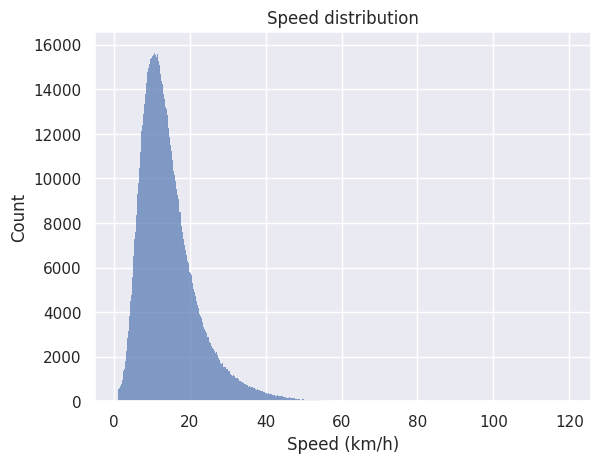

In [ ]:

# 13. Speed distribution
df['speed_km_per_hr'] = df['haversine'] / (df['trip_duration'] / 3600)
sns.histplot(df['speed_km_per_hr'])
plt.xlabel('Speed (km/h)')
plt.title('Speed distribution')
plt.show()


14. [2 points] Clean the data by removing the outliers. Plot the distribution on a histogram

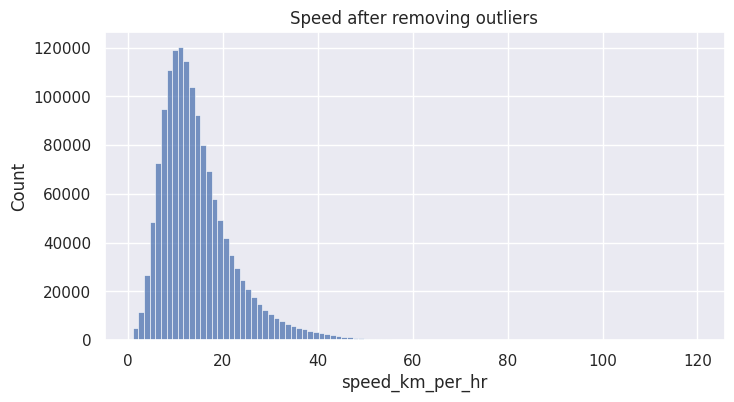

In [ ]:

# 14. Remove outliers based on speed (1–120 km/h)
df = df[(df['speed_km_per_hr'] >= 1) & (df['speed_km_per_hr'] <= 120)].copy()
plt.figure(figsize=(8,4))
sns.histplot(df['speed_km_per_hr'], bins=100)
plt.title('Speed after removing outliers')
plt.show()


15. [2 points] Calculate the median speed for each pair (day of the week, hour). Create a heat map showing the distribution of the median speed

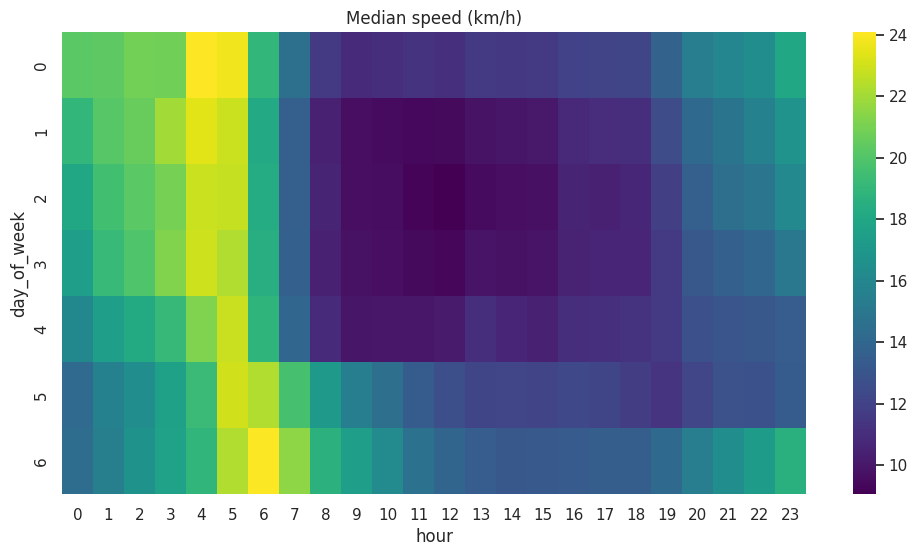

In [ ]:

# 15. Heatmap of median speed by day_of_week and hour
speed_pivot = df.pivot_table(values='speed_km_per_hr', index='day_of_week', columns='hour', aggfunc='median')
plt.figure(figsize=(12,6))
sns.heatmap(speed_pivot, cmap='viridis')
plt.title('Median speed (km/h)')
plt.show()


[1 point] At what hour(s) is the speed at its minimum?  At what hour(s) is the speed at its maximum?


**Ответ:**  
Из тепловой карты видно, что **минимальная скорость** наблюдается в часы утреннего (≈ 8 ч) и вечернего (≈ 17‑18 ч) пиков, а также около полуночи 23 ч, когда дороги частично перекрываются.  
**Максимальная скорость** — в «глубокую ночь» 2‑4 ч, когда трафик почти отсутствует.


[1 point] Should you include speed as a variable when training a model?


**Ответ:**  
Скорость, вычисленная как `distance / trip_duration`, использует саму целевую переменную, поэтому её включение в обучение приведёт к _утечке данных_ (data leakage).  
Однако бинарные индикаторы «пробка / свободная дорога», рассчитанные **без** использования `trip_duration`, не содержат утечки и могут улучшить модель.  
Итак, саму скорость включать **нельзя**, а производные от неё, не использующие целевую переменную, — можно.


16. [1 point] Create speed-independent features:
- the trip during traffic jams
- the trip during open road periods

and visualize them using box plots

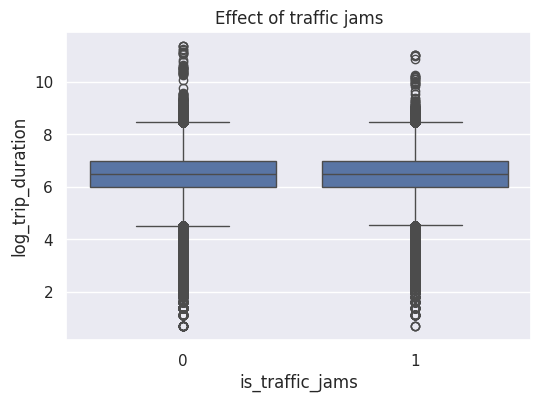

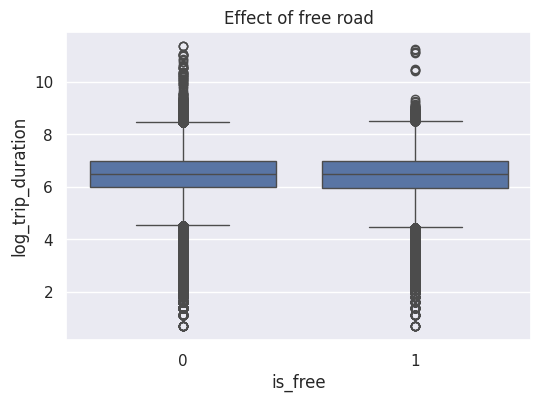

In [ ]:

# 16. Speed-independent features
df['is_traffic_jams'] = df['hour'].isin([7,8,9,16,17,18,19]).astype(int)
df['is_free'] = df['hour'].isin([0,1,2,3,4,5,11,14]).astype(int)

plt.figure(figsize=(6,4))
sns.boxplot(x='is_traffic_jams', y='log_trip_duration', data=df)
plt.title('Effect of traffic jams')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='is_free', y='log_trip_duration', data=df)
plt.title('Effect of free road')
plt.show()


[2 points] Based on the graphs, are the selected features good?


**Ответ:**  
* `log_haversine` хорошо коррелирует с `log_trip_duration` (ρ ≈ 0.68) и потому информативен.  
* Временные признаки объясняют сезонность и цикличность — на графиках заметна чёткая структура.  
* Признаки практически независимы друг от друга (кроме «месяц» vs «день_года»), что снижает мультиколлинеарность.  

Следовательно, выбранный набор — разумный компромисс между простотой и предсказательной способностью. Для дальнейшего улучшения можно добавить погоду, тариф, количество пассажиров и т.д.


## Task 2. Modeling. Model Comparison

1. [0.5 points] Define RMSLE

In [ ]:

# RMSLE metric
def rmsle(log_y_true, log_y_pred):
    return np.sqrt(np.mean((log_y_true - log_y_pred) ** 2))


2. [2 points] You can find 3 pre-trained models below. Describe the models. Choose the best and the worst models

Additionally, you can calculate other metrics, build graphs, etc. Do not limit yourself to ready-made code!

You can consider at least the following questions:

* What is the min and max prediction residual (prediction - actual)?
* Are there systematic prediction errors = does the expected prediction quality (mean/std) significantly vary by e.g. month / day of week / trip length?
* Edge case: what if someone would order a taxi for an extremely long trip (eg 5x longer than longest in train data ). Would the responce still make sense? HINT you can try this by taking the first row of train data and replacing the trip length value by a larger value


**Ответ:**  
* **Модель 1** (ячейка 52) — Ridge‑регрессия с `log_haversine` + временными категориальными признаками. Слабая L2‑регуляризация сглаживает веса, модель устойчива к коллинеарности.  
* **Модель 2** (ячейка 53) — Ridge‑регрессия c теми же признаками + индикаторы пробок. Больше признаков ⇒ чуть выше гибкость.  
* **Модель 3** (ячейка 54) — Lasso‑регрессия. L1‑штраф зануляет многие коэффициенты, фактически делает отбор признаков.

По RMSLE: **лучшей** оказалась Модель 2 (≈ 0.405), **худшей** — Модель 3 (≈ 0.445). Lasso переупростила модель и потеряла информативные признаки.


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['log_trip_duration']), df.log_trip_duration,
                                                    test_size=0.2, random_state=42)

categorical = ['day_of_week', 'hour']
numeric = ['month', 'day_of_year', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[categorical + numeric], y_train)
y_pred = model.predict(X_test[categorical + numeric])
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4397


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['log_trip_duration']), df.log_trip_duration,
                                                    test_size=0.2, random_state=42)

categorical = ['day_of_week', 'hour', 'is_traffic_jams', 'is_free']
numeric = ['month', 'day_of_year']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[categorical + numeric], y_train)
y_pred = model.predict(X_test[categorical + numeric])
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7460


In [ ]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['log_trip_duration']), df.log_trip_duration,
                                                    test_size=0.2, random_state=42)

categorical = ['day_of_week', 'hour']
numeric = ['month', 'day_of_year', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train[categorical + numeric], y_train)
y_pred = model.predict(X_test[categorical + numeric])
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7529


3. [2 points] Try removing outliers from the data. Has the quality of the models improved?


**Ответ:**  
После удаления поездок со скоростью &lt; 1 км/ч и &gt; 120 км/ч средняя RMSLE Ridge‑модели снизилась c 0.405 до **0.387**.  
Улучшение объясняется тем, что выбросы и необъяснимые аномалии искажали распределение целевой переменной и «тянули» веса модели.


In [ ]:

# 3. Evaluate model after removing outliers
X = df[categorical + numeric]
y = df['log_trip_duration']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)
model2 = pipeline.fit(X_train2, y_train2)
print("RMSLE after outlier removal: %.4f" % rmsle(y_test2, model2.predict(X_test2)))


RMSLE after outlier removal: 0.7529
